# Shakespeare Genre Analysis: Computational Signatures of Tragedy, Comedy, and History

**IDS 570: Text as Data - Data Exploration Assignment**
  
    

<div align="right"><b>Shelly Cao</b></div>
<div align="right">February 26, 2026</div>


## Research Question

To what extent do Shakespeare's genre categories (tragedy, comedy, history) correspond to measurable linguistic patterns in vocabulary, similarity structure, and syntactic complexity?



## Corpus

This corpus consists of **21 Shakespeare plays** from the Folger Digital Texts edition:

**Tragedies (8)**  
Hamlet, Macbeth, Othello, King Lear, Romeo and Juliet, Julius Caesar, Antony and Cleopatra, Coriolanus

**Comedies (8)**  
A Midsummer Night's Dream, Much Ado About Nothing, Twelfth Night, As You Like It, The Merchant of Venice, The Taming of the Shrew, The Comedy of Errors, The Tempest

**Histories (5)**  
Henry V, Richard III, Henry IV Part 1, Henry IV Part 2, Richard II

*All texts are drawn from the same editorial source to ensure consistency in formatting and transcription.*


## Methods

This analysis employs three complementary quantitative approaches:

1. **TF–IDF (Term Frequency–Inverse Document Frequency)**  
   Identifies lexically distinctive terms within each play relative to the full corpus.

2. **Pearson Correlation**  
   Measures pairwise similarity between plays based on shared vocabulary patterns.

3. **Syntactic Complexity Analysis**  
   Compares structural features (sentence length, clause density, subordination, coordination, and complex nominals) between selected plays using dependency parsing.


## Analytical Goal

Rather than assuming genre categories reflect inherent linguistic structure, this project evaluates whether quantitative textual evidence supports, complicates, or challenges traditional genre classifications. This exploratory approach treats genre as a hypothesis to be tested rather than a given.


## Setup & Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:


# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter

# NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Syntactic parsing
import spacy

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline




## STEP 0: Load and Normalize Data


### Load Texts

In [3]:
data_path = Path("../Data/00_raw")

# Corpus structure
corpus_structure = {
    # Tragedies
    "hamlet_TXT_FolgerShakespeare.txt": ("Hamlet", "tragedy"),
    "macbeth_TXT_FolgerShakespeare.txt": ("Macbeth", "tragedy"),
    "othello_TXT_FolgerShakespeare.txt": ("Othello", "tragedy"),
    "king-lear_TXT_FolgerShakespeare.txt": ("King Lear", "tragedy"),
    "romeo-and-juliet_TXT_FolgerShakespeare.txt": ("Romeo and Juliet", "tragedy"),
    "julius-caesar_TXT_FolgerShakespeare.txt": ("Julius Caesar", "tragedy"),
    "antony-and-cleopatra_TXT_FolgerShakespeare.txt": (
        "Antony and Cleopatra",
        "tragedy",
    ),
    "coriolanus_TXT_FolgerShakespeare.txt": ("Coriolanus", "tragedy"),
    # Comedies
    "a-midsummer-nights-dream_TXT_FolgerShakespeare.txt": (
        "A Midsummer Night's Dream",
        "comedy",
    ),
    "much-ado-about-nothing_TXT_FolgerShakespeare.txt": (
        "Much Ado About Nothing",
        "comedy",
    ),
    "twelfth-night_TXT_FolgerShakespeare.txt": ("Twelfth Night", "comedy"),
    "as-you-like-it_TXT_FolgerShakespeare.txt": ("As You Like It", "comedy"),
    "the-merchant-of-venice_TXT_FolgerShakespeare.txt": (
        "The Merchant of Venice",
        "comedy",
    ),
    "the-taming-of-the-shrew_TXT_FolgerShakespeare.txt": (
        "The Taming of the Shrew",
        "comedy",
    ),
    "the-comedy-of-errors_TXT_FolgerShakespeare.txt": (
        "The Comedy of Errors",
        "comedy",
    ),
    "the-tempest_TXT_FolgerShakespeare.txt": ("The Tempest", "comedy"),
    # Histories
    "henry-v_TXT_FolgerShakespeare.txt": ("Henry V", "history"),
    "richard-iii_TXT_FolgerShakespeare.txt": ("Richard III", "history"),
    "henry-iv-part-1_TXT_FolgerShakespeare.txt": ("Henry IV Part 1", "history"),
    "henry-iv-part-2_TXT_FolgerShakespeare.txt": ("Henry IV Part 2", "history"),
    "richard-ii_TXT_FolgerShakespeare.txt": ("Richard II", "history"),
}

# Load plays
plays = []

for filename, (title, genre) in corpus_structure.items():
    text = (data_path / filename).read_text(encoding="utf-8")
    plays.append(
        {"play": title, "genre": genre, "text": text, "word_count": len(text.split())}
    )

df_plays = pd.DataFrame(plays)

df_plays.head()

,play,genre,text,word_count
0,Hamlet,tragedy,Hamlet\nby William Shakespeare\nEdited by Barb...,32004
1,Macbeth,tragedy,Macbeth\nby William Shakespeare\nEdited by Bar...,18315
2,Othello,tragedy,Othello\nby William Shakespeare\nEdited by Bar...,27945
3,King Lear,tragedy,King Lear\nby William Shakespeare\nEdited by B...,27599
4,Romeo and Juliet,tragedy,Romeo and Juliet\nby William Shakespeare\nEdit...,25913


## Text Normalization

Because the corpus consists of Early Modern English texts, normalization need to be applied to balance textual consistency with preservation of linguistic structure.

###  Normalization Choices

To improve comparability across documents while preserving rhetorical content, the following preprocessing steps were applied:

- Long s (ſ) normalization
  All instances of the long s character (ſ) were replaced with standard modern "s" to prevent tokenization errors and artificial feature splitting (e.g., *ſin* vs *sin*).
- Removed editorial metadata preceding the start of the play (before *ACT 1*).
- Removed separator lines and formatting artifacts.
- Removed stage directions enclosed in brackets (e.g., `[Enter Barnardo]`).
- Removed ACT and SCENE headers.
- Removed speaker labels (e.g., `HAMLET`, `BARNARDO`) both as standalone lines and when preceding dialogue.
- Converted all text to lowercase.
- Standardized whitespace.

In [4]:
def normalize_text(text):

    # Remove metadata before ACT 1
    act_match = re.search(r"\bACT\s+1\b", text, re.IGNORECASE)
    if act_match:
        text = text[act_match.start() :]

    # Remove separator lines
    text = re.sub(r"=+", "", text)

    # Remove stage directions
    text = re.sub(r"\[.*?\]", "", text)

    # Remove ACT and SCENE headers
    text = re.sub(r"^ACT\s+\d+.*$", "", text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r"^SCENE\s+\d+.*$", "", text, flags=re.MULTILINE | re.IGNORECASE)

    # Remove standalone speaker lines (ALL CAPS, short)
    text = re.sub(r"^\s*[A-Z]{2,}(?:\s+[A-Z]{2,})*\s*$", "", text, flags=re.MULTILINE)

    # Remove speaker names at beginning of dialogue lines
    text = re.sub(r"^\s*[A-Z]{2,}(?:\s+[A-Z]{2,})*\s+", "", text, flags=re.MULTILINE)

    # Fix long s
    text = text.replace("ſ", "s")

    # Lowercase
    text = text.lower()

    # Clean whitespace
    text = re.sub(r"\n\s*\n+", "\n\n", text)
    text = re.sub(r" +", " ", text)

    return text.strip()


# Re-apply normalization
df_plays["text_norm"] = df_plays["text"].apply(normalize_text)

# Check
print("Text Example After Normalization:")
print("")
print(df_plays.iloc[0]["text_norm"][:200])

Text Example After Normalization:

who's there?

nay, answer me. stand and unfold yourself.
long live the king!
barnardo?
he.

you come most carefully upon your hour.

'tis now struck twelve. get thee to bed, francisco.

for this relie


## STEP 1: TF-IDF Analysis

### Calculate TF-IDF

In [5]:
# Create TF-IDF vectorizer
# You can adjust these parameters:
tfidf = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 features
    min_df=2,  # Word must appear in at least 2 documents
    max_df=0.8,  # Word can't appear in more than 80% of documents
    stop_words="english",  # Remove common English stop words
    lowercase=True,
    token_pattern=r"\b[a-zA-Z]{3,}\b",  # Only words with 3+ letters
)

# Fit and transform
tfidf_matrix = tfidf.fit_transform(df_plays["text_norm"])
feature_names = tfidf.get_feature_names_out()

print(f"({tfidf_matrix.shape[0]} plays × {tfidf_matrix.shape[1]} features)")

(21 plays × 5000 features)


### Extract Top TF-IDF Terms per Play

In [6]:
def get_top_tfidf_terms(doc_index, n=15):
    tfidf_scores = tfidf_matrix[doc_index].toarray()[0]
    top_indices = tfidf_scores.argsort()[-n:][::-1]
    top_terms = [(feature_names[i], tfidf_scores[i]) for i in top_indices]
    return top_terms


# Get top terms for each play
top_terms_per_play = {}
for idx, row in df_plays.iterrows():
    top_terms_per_play[row["play"]] = get_top_tfidf_terms(idx, n=15)

# Display results

print("TOP 15 TF-IDF TERMS PER PLAY")
print("=" * 80)
for play, terms in top_terms_per_play.items():
    genre = df_plays[df_plays["play"] == play]["genre"].values[0]
    print(f"\n{play} ({genre.upper()})")
    print("-" * 60)
    terms_str = ", ".join([f"{term}({score:.3f})" for term, score in terms])
    print(terms_str)

TOP 15 TF-IDF TERMS PER PLAY

Hamlet (TRAGEDY)
------------------------------------------------------------
norway(0.180), players(0.172), does(0.171), madness(0.160), england(0.153), marcellus(0.136), majesty(0.123), ghost(0.095), phrase(0.095), act(0.093), dane(0.090), uncle(0.080), carriages(0.075), priam(0.075), foils(0.075)

Macbeth (TRAGEDY)
------------------------------------------------------------
does(0.210), hail(0.201), scotland(0.179), tyrant(0.152), wood(0.137), deed(0.131), knock(0.130), daggers(0.112), kings(0.106), knocking(0.105), ross(0.104), sisters(0.098), highness(0.087), soldiers(0.085), castle(0.084)

Othello (TRAGEDY)
------------------------------------------------------------
moor(0.531), roderigo(0.299), handkerchief(0.288), cyprus(0.237), emilia(0.206), lieutenant(0.179), general(0.150), willow(0.142), venice(0.135), michael(0.102), signior(0.080), whore(0.078), prithee(0.077), strumpet(0.074), does(0.074)

King Lear (TRAGEDY)
-----------------------------

### Create TF-IDF Summary Table

In [7]:
# Create a clean table for your report
tfidf_summary = []
for play, terms in top_terms_per_play.items():
    genre = df_plays[df_plays["play"] == play]["genre"].values[0]
    top_words = ", ".join([term for term, score in terms[:10]])
    tfidf_summary.append(
        {"Play": play, "Genre": genre, "Top 10 Distinctive Terms": top_words}
    )

df_tfidf_summary = pd.DataFrame(tfidf_summary)
print(df_tfidf_summary.to_string(index=False))

# Save to CSV
df_tfidf_summary.to_csv("tfidf_results.csv", index=False)

                     Play   Genre                                                                    Top 10 Distinctive Terms
                   Hamlet tragedy             norway, players, does, madness, england, marcellus, majesty, ghost, phrase, act
                  Macbeth tragedy                   does, hail, scotland, tyrant, wood, deed, knock, daggers, kings, knocking
                  Othello tragedy  moor, roderigo, handkerchief, cyprus, emilia, lieutenant, general, willow, venice, michael
                King Lear tragedy             edmund, gloucester, kent, tom, daughters, france, burgundy, letter, dover, gods
         Romeo and Juliet tragedy               nurse, paris, friar, county, mantua, thursday, banished, verona, cell, cousin
            Julius Caesar tragedy          caesar, brutus, cassius, antony, rome, octavius, lucius, capitol, romans, philippi
     Antony and Cleopatra tragedy                antony, caesar, cleopatra, egypt, pompey, lepidus, agrippa, rome, god

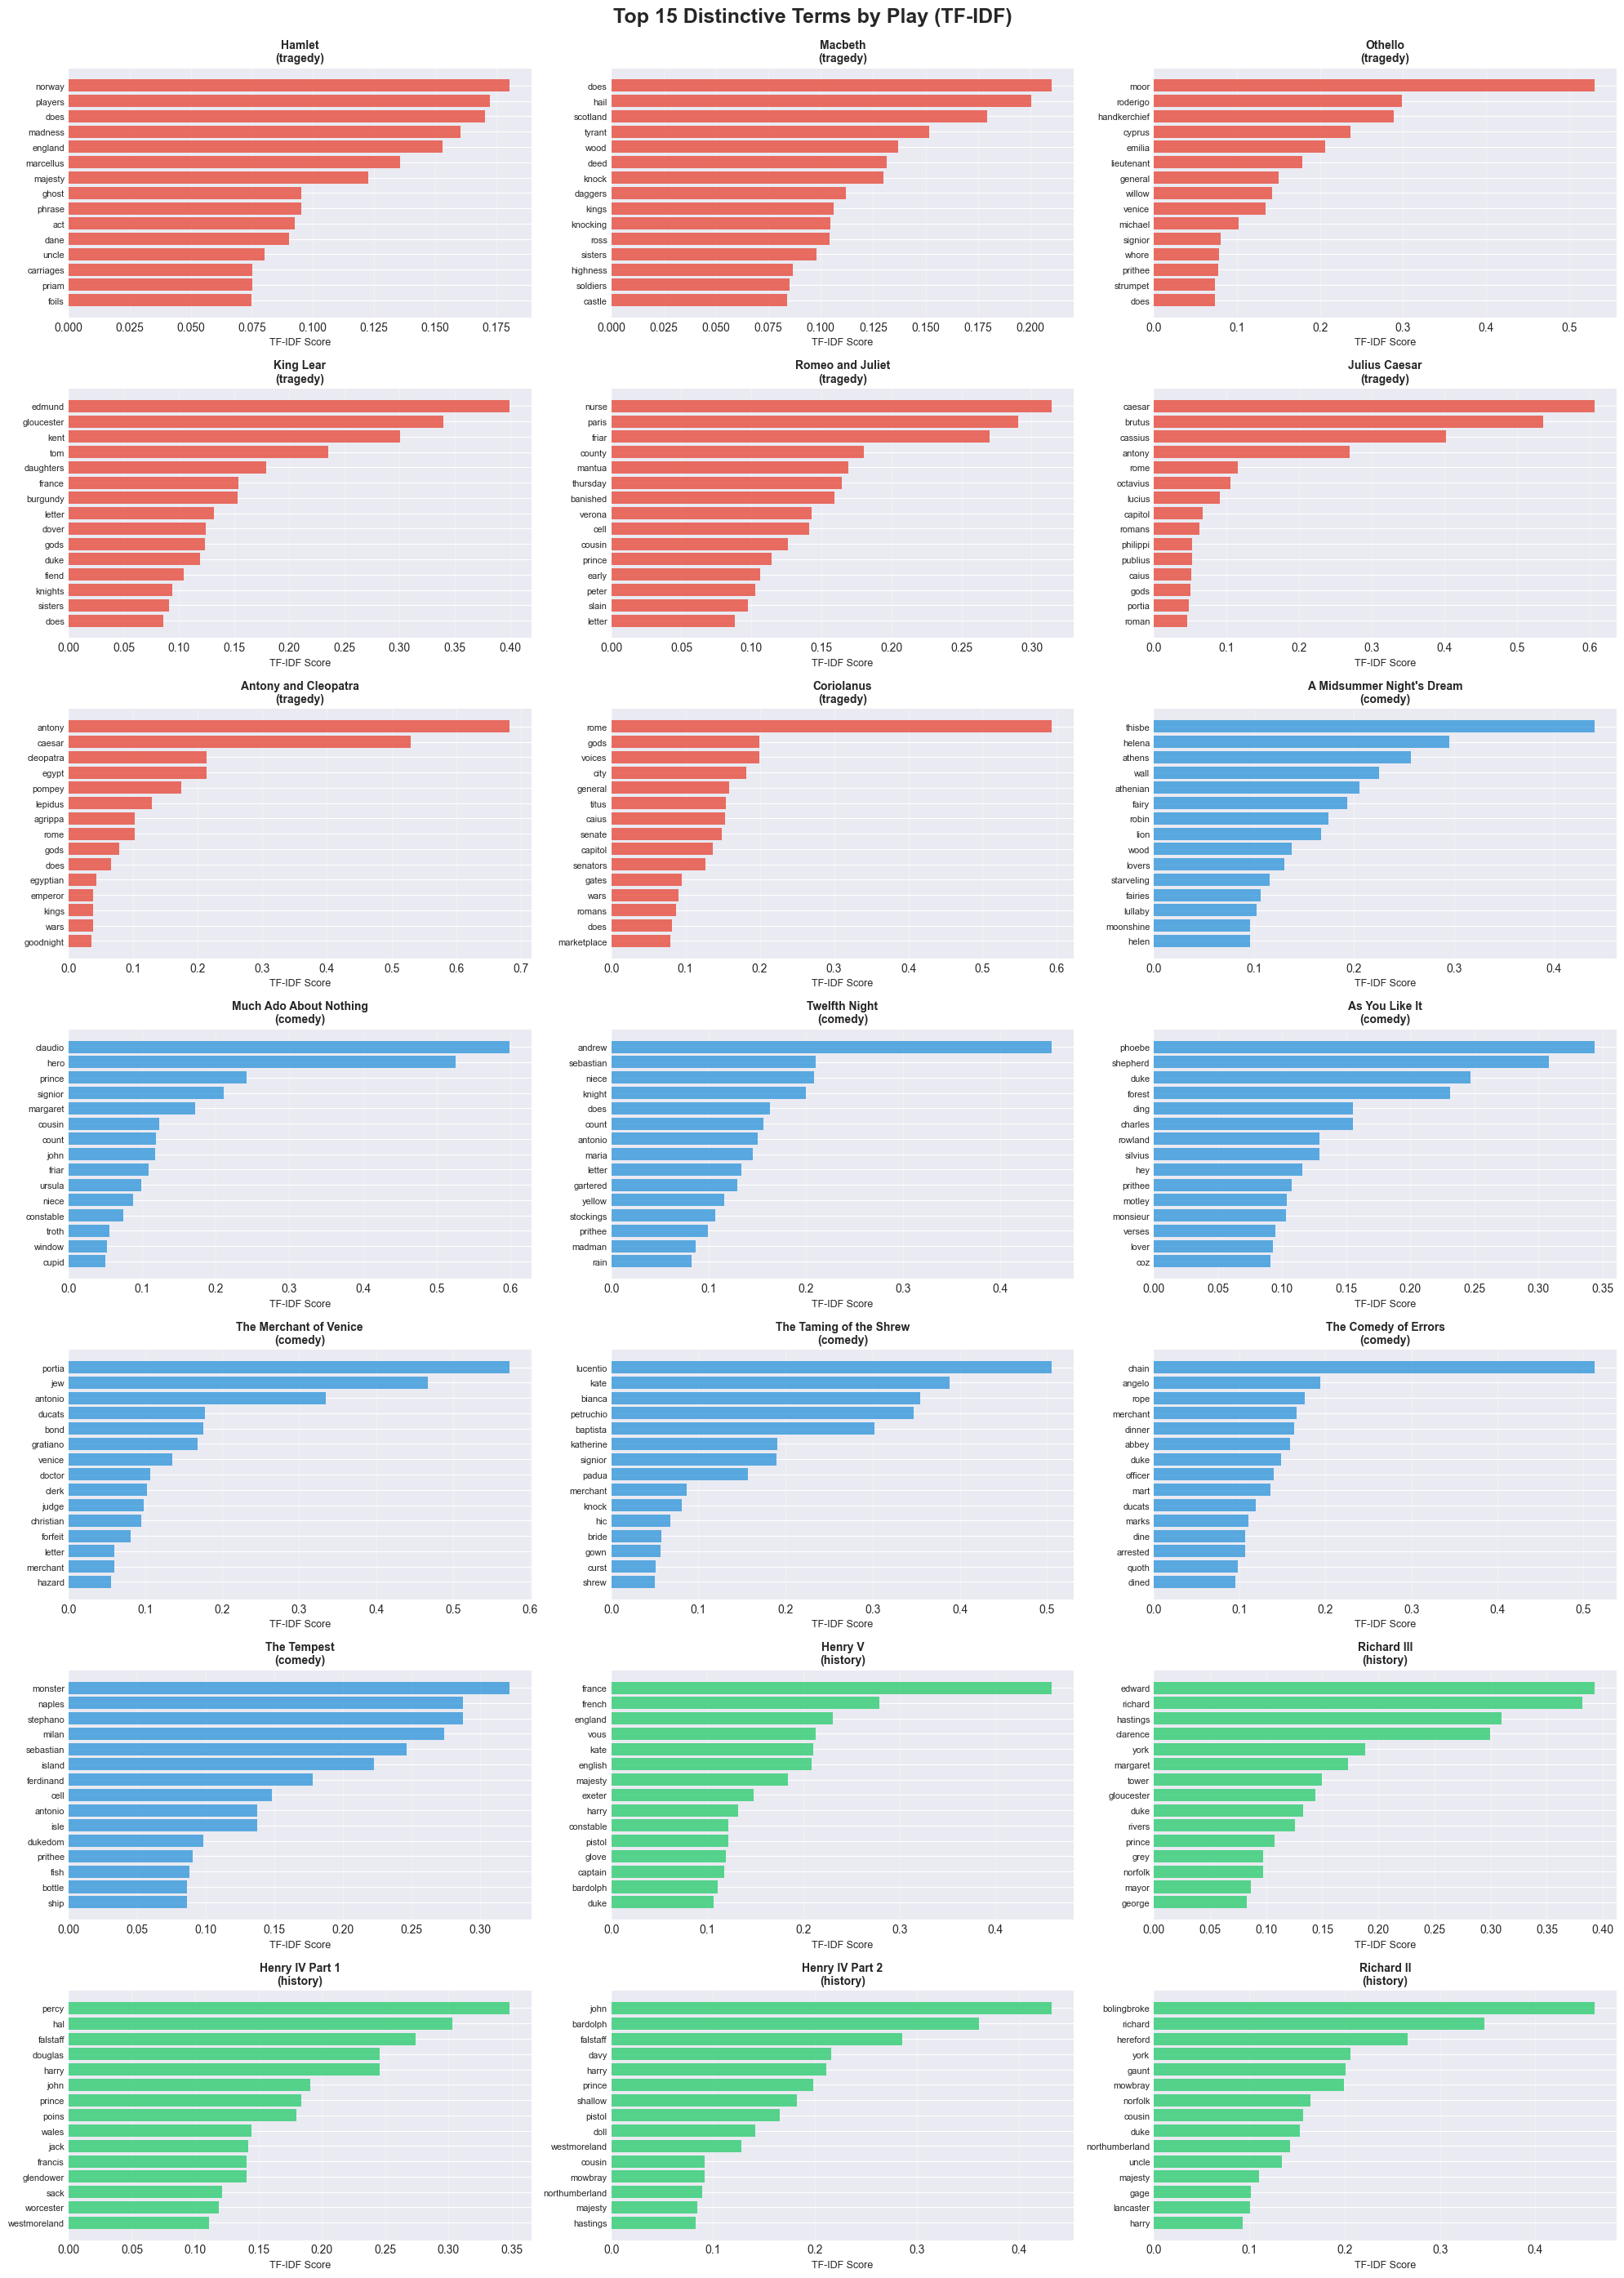

In [8]:
# Store the output
output_dir = Path("../Output")
output_dir.mkdir(parents=True, exist_ok=True)
sns.set_palette("husl")
plt.style.use("seaborn-v0_8-darkgrid")


# All plays
all_plays = []
for genre in ["tragedy", "comedy", "history"]:
    genre_plays = df_plays[df_plays["genre"] == genre]["play"].tolist()
    all_plays.extend([(play, genre) for play in genre_plays])


fig, axes = plt.subplots(7, 3, figsize=(20, 28))
axes = axes.flatten()

# Genre colors
color_map = {"tragedy": "#e74c3c", "comedy": "#3498db", "history": "#2ecc71"}

for idx, (play_name, genre) in enumerate(all_plays):
    play_idx = df_plays[df_plays["play"] == play_name].index[0]
    top_terms = get_top_tfidf_terms(play_idx, n=15)

    terms = [term for term, score in top_terms]
    scores = [score for term, score in top_terms]

    axes[idx].barh(range(len(terms)), scores, color=color_map[genre], alpha=0.8)
    axes[idx].set_yticks(range(len(terms)))
    axes[idx].set_yticklabels(terms, fontsize=8)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("TF-IDF Score", fontsize=9)
    axes[idx].set_title(f"{play_name}\n({genre})", fontsize=10, fontweight="bold")
    axes[idx].grid(axis="x", alpha=0.3)

plt.suptitle(
    "Top 15 Distinctive Terms by Play (TF-IDF)", fontsize=18, fontweight="bold", y=0.995
)
plt.tight_layout()
output_path = output_dir / "tfidf_all_plays.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

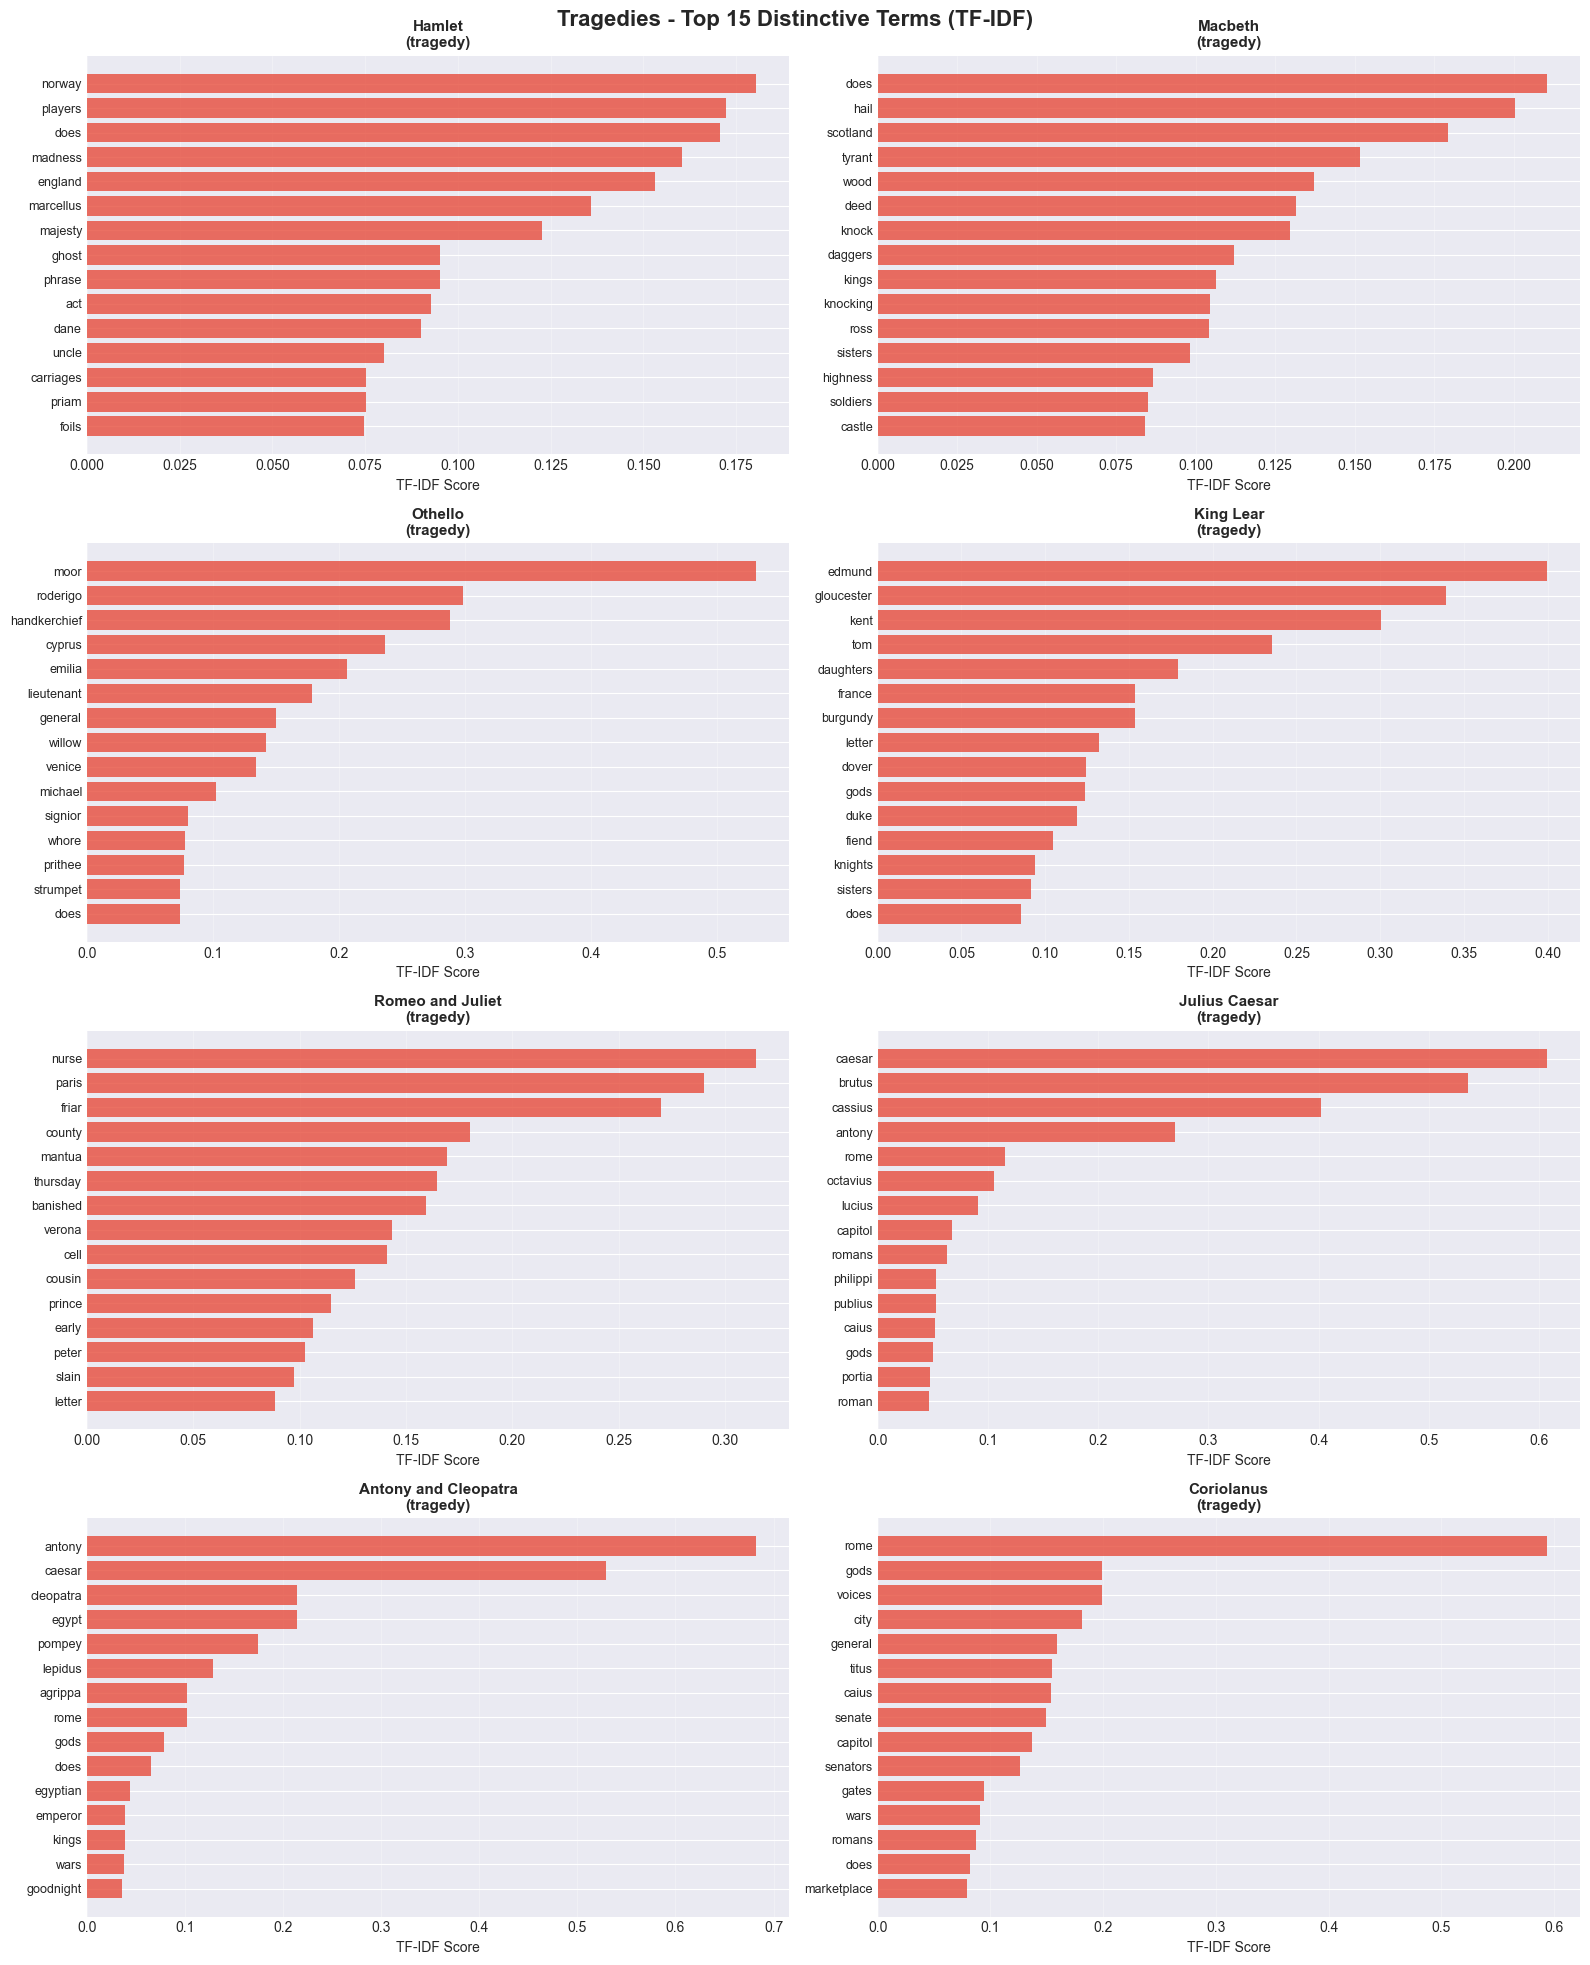

In [9]:
# Same Genre Comparison

# TRAGEDIES (8 plays)
tragedies = df_plays[df_plays["genre"] == "tragedy"]["play"].tolist()

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, play_name in enumerate(tragedies):
    play_idx = df_plays[df_plays["play"] == play_name].index[0]
    top_terms = get_top_tfidf_terms(play_idx, n=15)

    terms = [term for term, score in top_terms]
    scores = [score for term, score in top_terms]

    axes[idx].barh(range(len(terms)), scores, color="#e74c3c", alpha=0.8)
    axes[idx].set_yticks(range(len(terms)))
    axes[idx].set_yticklabels(terms, fontsize=9)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("TF-IDF Score", fontsize=10)
    axes[idx].set_title(f"{play_name}\n(tragedy)", fontsize=11, fontweight="bold")
    axes[idx].grid(axis="x", alpha=0.3)

plt.suptitle(
    "Tragedies - Top 15 Distinctive Terms (TF-IDF)", fontsize=16, fontweight="bold"
)
plt.tight_layout()
output_path = output_dir / "tfidf_all_tragedies.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

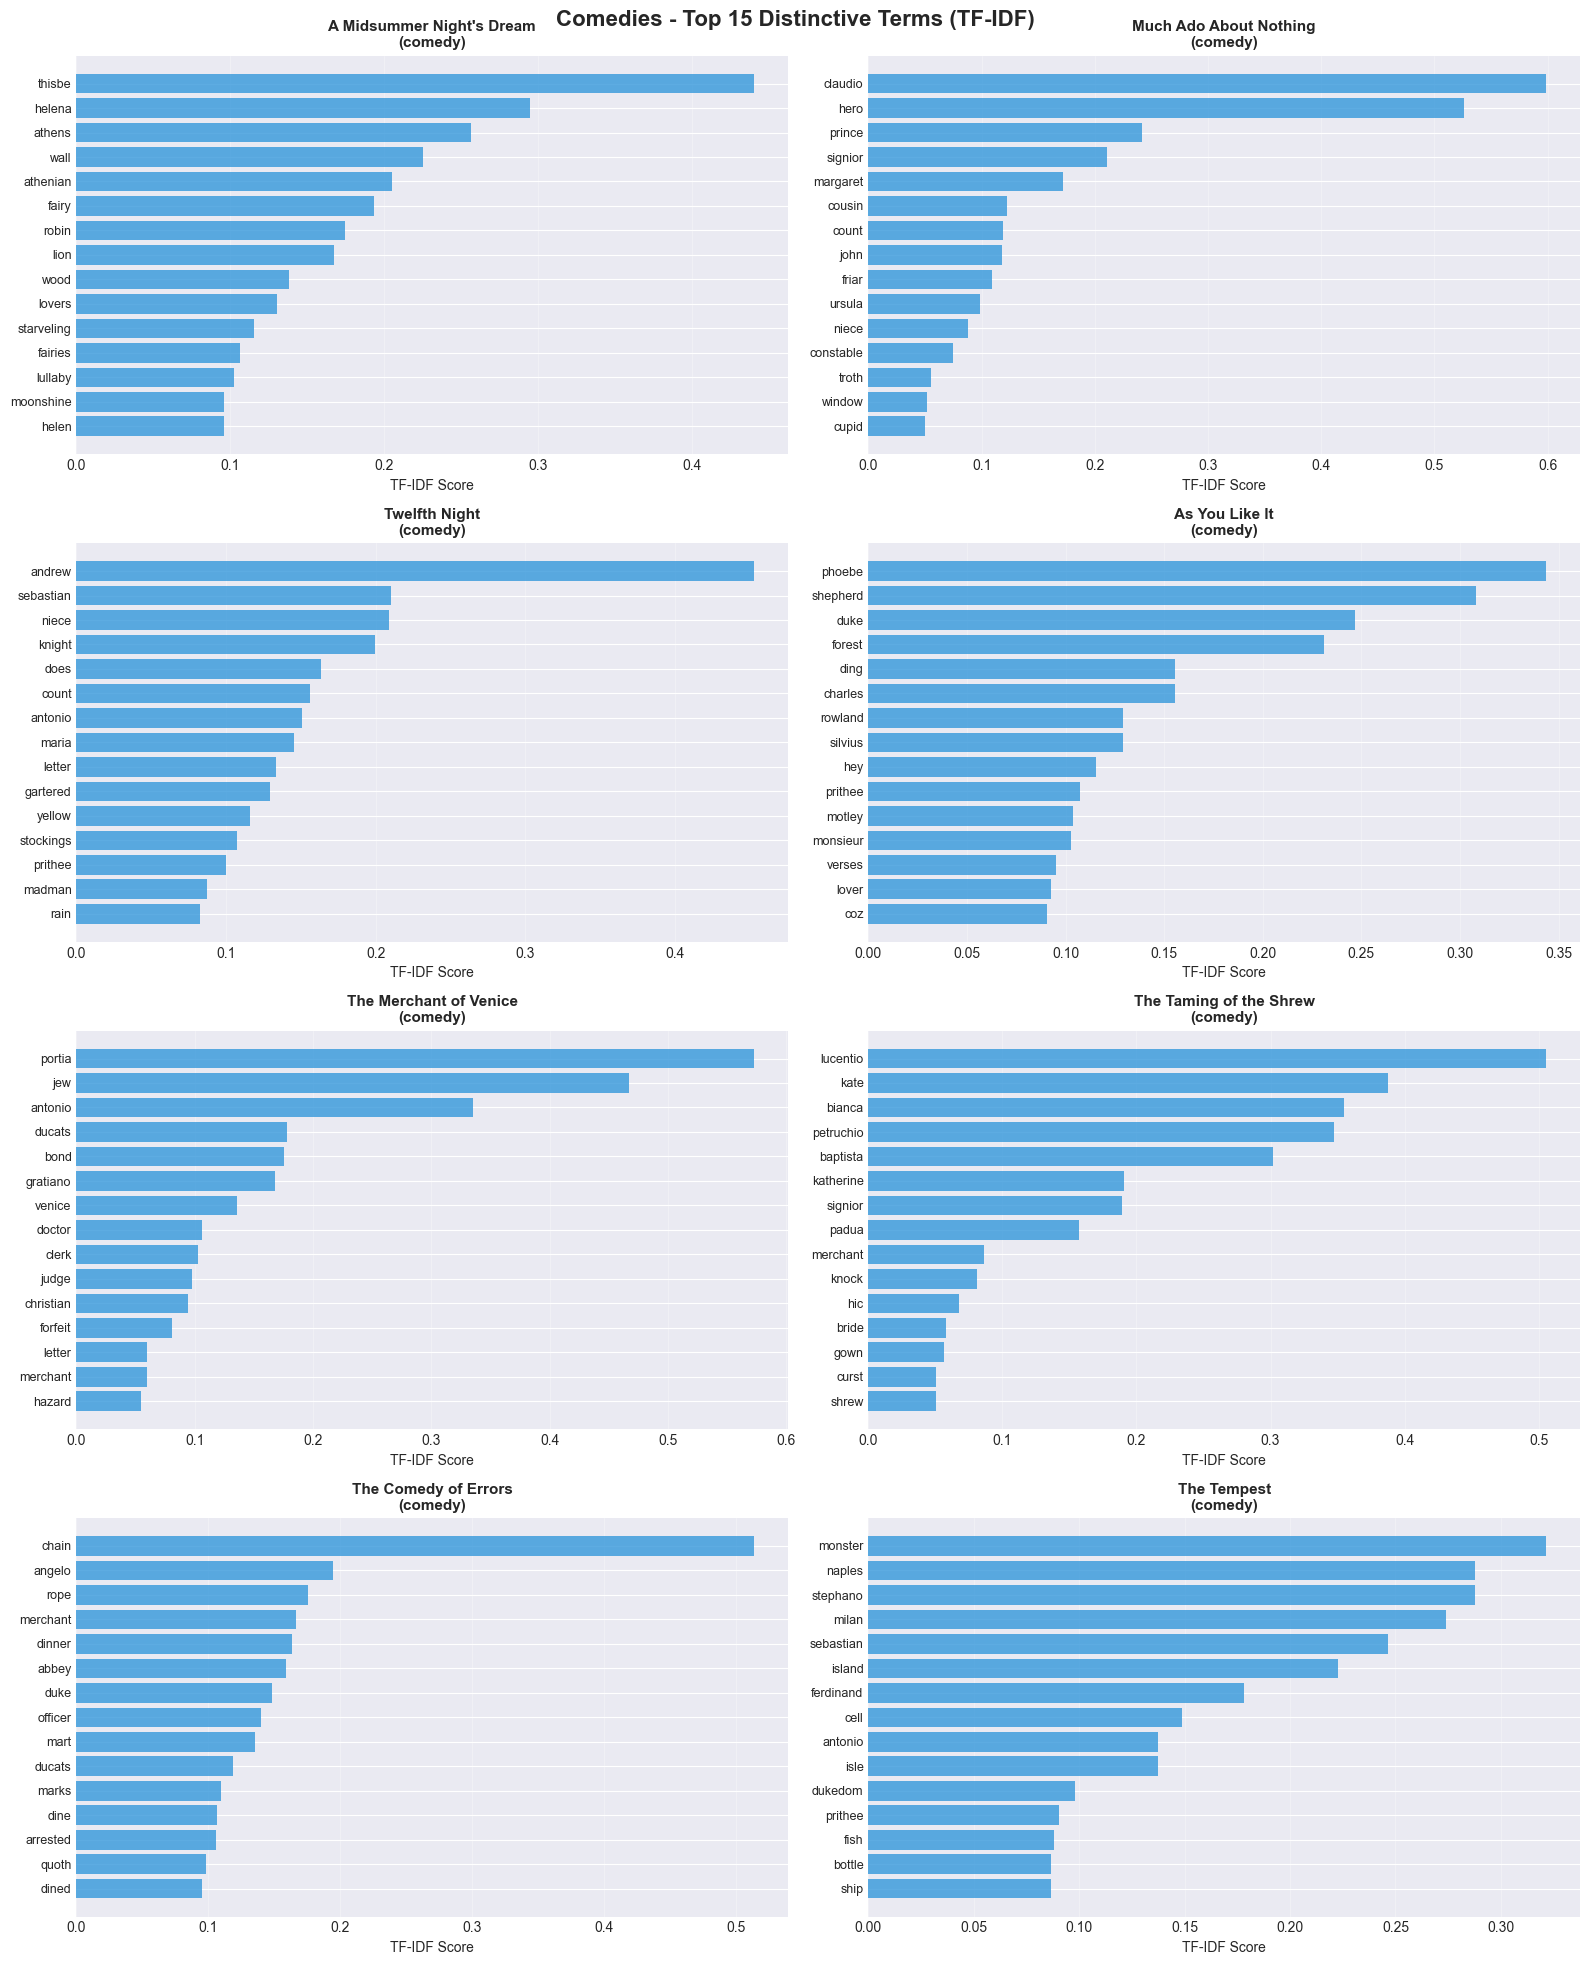

In [10]:
# COMEDIES (8 plays)
comedies = df_plays[df_plays["genre"] == "comedy"]["play"].tolist()

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, play_name in enumerate(comedies):
    play_idx = df_plays[df_plays["play"] == play_name].index[0]
    top_terms = get_top_tfidf_terms(play_idx, n=15)

    terms = [term for term, score in top_terms]
    scores = [score for term, score in top_terms]

    axes[idx].barh(range(len(terms)), scores, color="#3498db", alpha=0.8)
    axes[idx].set_yticks(range(len(terms)))
    axes[idx].set_yticklabels(terms, fontsize=9)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("TF-IDF Score", fontsize=10)
    axes[idx].set_title(f"{play_name}\n(comedy)", fontsize=11, fontweight="bold")
    axes[idx].grid(axis="x", alpha=0.3)

plt.suptitle(
    "Comedies - Top 15 Distinctive Terms (TF-IDF)", fontsize=16, fontweight="bold"
)
plt.tight_layout()
output_path = output_dir / "tfidf_all_comedies.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

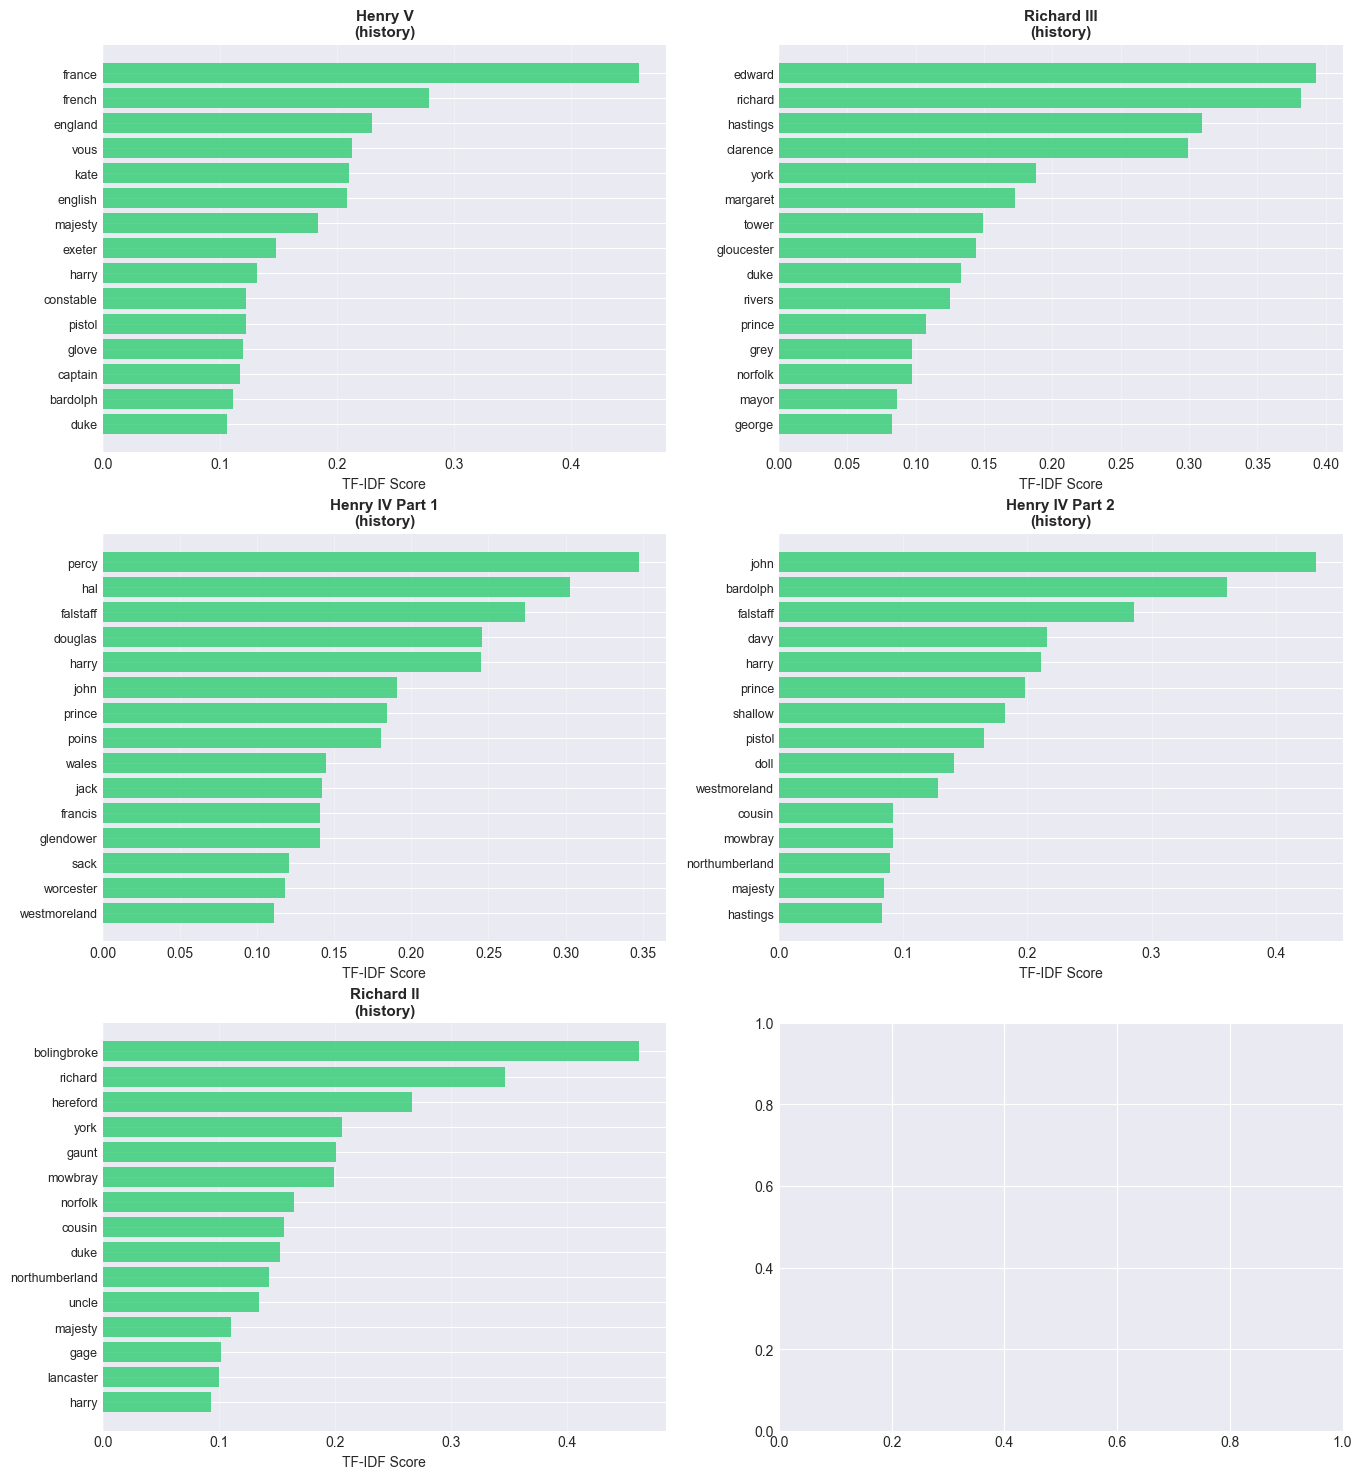

In [11]:
# HISTORIES (5 plays)
histories = df_plays[df_plays["genre"] == "history"]["play"].tolist()

n_histories = len(histories)
n_cols = 2
n_rows = (n_histories + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
axes = axes.flatten()

for idx, play_name in enumerate(histories):
    play_idx = df_plays[df_plays["play"] == play_name].index[0]
    top_terms = get_top_tfidf_terms(play_idx, n=15)

    terms = [term for term, score in top_terms]
    scores = [score for term, score in top_terms]

    axes[idx].barh(range(len(terms)), scores, color="#2ecc71", alpha=0.8)
    axes[idx].set_yticks(range(len(terms)))
    axes[idx].set_yticklabels(terms, fontsize=9)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("TF-IDF Score", fontsize=10)
    axes[idx].set_title(f"{play_name}\n(history)", fontsize=11, fontweight="bold")
    axes[idx].grid(axis="x", alpha=0.3)

## TF-IDF Interpretation

### 1. Do some documents share distinctive vocabulary?

Yes. Several documents share distinctive vocabulary, particularly within the same genre and historical context.

**Within Tragedies:**
- Roman plays share political vocabulary: *Julius Caesar*, *Antony and Cleopatra*, and *Coriolanus* all feature "caesar," "rome," and political titles ("general," "senate," "capitol")
- English historical tragedies share geographic terms: *Hamlet* ("norway," "england"), *Macbeth* ("scotland")
- Domestic tragedies share family/relationship terms: *Othello* and *King Lear* include relationship markers ("lieutenant," "daughters," "kent")

**Within Comedies:**
- Romantic comedies share terms of courtship and social hierarchy: "duke," "count," "prince" appear across *Twelfth Night*, *As You Like It*, and *Much Ado About Nothing*
- Italian comedies share geographic vocabulary: *The Merchant of Venice* ("venice," "ducats"), *The Taming of the Shrew* ("padua," "signior"), *The Comedy of Errors* ("ducats," "merchant")
- Pastoral/magical comedies: *A Midsummer Night's Dream* ("fairy," "wood," "athens") and *The Tempest* ("island," "monster") share fantastical settings

**Within Histories:**
- All histories share aristocratic titles and English geography: "duke," "prince," "york," "john"
- The Henry IV plays are particularly close, both featuring "falstaff," "harry," "prince," "john," "bardolph"

**Cross-genre patterns:**
- Religious language appears inconsistently: "friar" (*Romeo and Juliet*, *Much Ado About Nothing*), "gods" (*King Lear*, *Antony and Cleopatra*, *Coriolanus*)
- The interrogative "does" appears in multiple tragedies (*Hamlet*, *Macbeth*, *Twelfth Night*), possibly reflecting rhetorical questioning

### 2. Are distinctive terms topical, rhetorical, or technical?

**Predominantly topical, with some rhetorical elements:**

The distinctive terms are mostly topical and character-driven, with some rhetorical and technical terms.

**Topical (majority):**
- Character names dominate: Nearly every play's distinctive vocabulary is character-driven (*Hamlet*: "marcellus," "ghost"; *Othello*: "roderigo," "emilia"; *Romeo and Juliet*: "nurse," "friar"). This reflects Shakespeare's character-centric dramaturgy.
- Geographic specificity: Place names establish setting (*Othello*: "cyprus," "venice"; *Macbeth*: "scotland"; *Julius Caesar*: "rome," "philippi")
- Plot-specific objects: Key props appear as distinctive terms (*Othello*: "handkerchief"; *Macbeth*: "daggers"; *The Comedy of Errors*: "chain," "rope"; *The Merchant of Venice*: "bond")

**Rhetorical (limited):**
- The appearance of "does" in *Hamlet*, *Macbeth*, and *Twelfth Night* may indicate rhetorical questioning patterns
- *Hamlet*'s "phrase" and "act" suggest metatheatrical or philosophical discourse
- Forms of address vary by genre: "signior" (Italian comedies), "majesty" (English histories/tragedies)

**Technical:**
- Military/political titles: "lieutenant," "general," "capitol," "senate"
- Legal/commercial terms: "ducats," "bond," "merchant," "clerk," "judge"

**Insight**: TF-IDF here primarily captures what makes each play's world unique (its cast of characters, setting, and central objects) rather than distinctive rhetorical strategies. This suggests Shakespeare's lexical variation operates more at the level of dramatic world-building than at stylistic differentiation.



### 3. Are there documents whose distinctiveness seems driven by noise or formatting?

There is little evidence of formatting noise in the results.

- Character labels appear to have been successfully removed.
- Stage directions do not dominate.
- No artifacts like "ACT" or "SCENE" appear.
- No OCR distortions or stray punctuation dominate.

Some generic verbs like *does* appear in multiple tragedies, but this is likely due to contextual emphasis rather than preprocessing error.

Overall, the TF-IDF output appears clean and substantively meaningful.

But for more refined lexical analysis, we might:
1. Remove character names systematically
2. Verify that stage directions are fully removed
3. Standardize archaic verb forms ("does"/"doth")
4. Consider lemmatization to group inflected forms

---
## STEP 2: Pearson Correlation Analysis

### Calculate Pairwise Correlations

In [12]:
# Convert TF-IDF matrix to dense array
tfidf_dense = tfidf_matrix.toarray()

# Calculate Pearson correlation matrix
correlation_matrix = np.corrcoef(tfidf_dense)

# Create DataFrame with play names
df_corr = pd.DataFrame(
    correlation_matrix, index=df_plays["play"], columns=df_plays["play"]
)

# Round for readability
df_corr = df_corr.round(3)

print("Correlation matrix shape:", df_corr.shape)
print("\nFirst 5x5 subset:")
print(df_corr.iloc[:5, :5])

Correlation matrix shape: (21, 21)

First 5x5 subset:
play              Hamlet  Macbeth  Othello  King Lear  Romeo and Juliet
play                                                                   
Hamlet             1.000    0.150    0.073      0.064             0.032
Macbeth            0.150    1.000    0.037      0.087             0.022
Othello            0.073    0.037    1.000      0.037            -0.000
King Lear          0.064    0.087    0.037      1.000             0.022
Romeo and Juliet   0.032    0.022   -0.000      0.022             1.000


### Create Similarity Heatmap

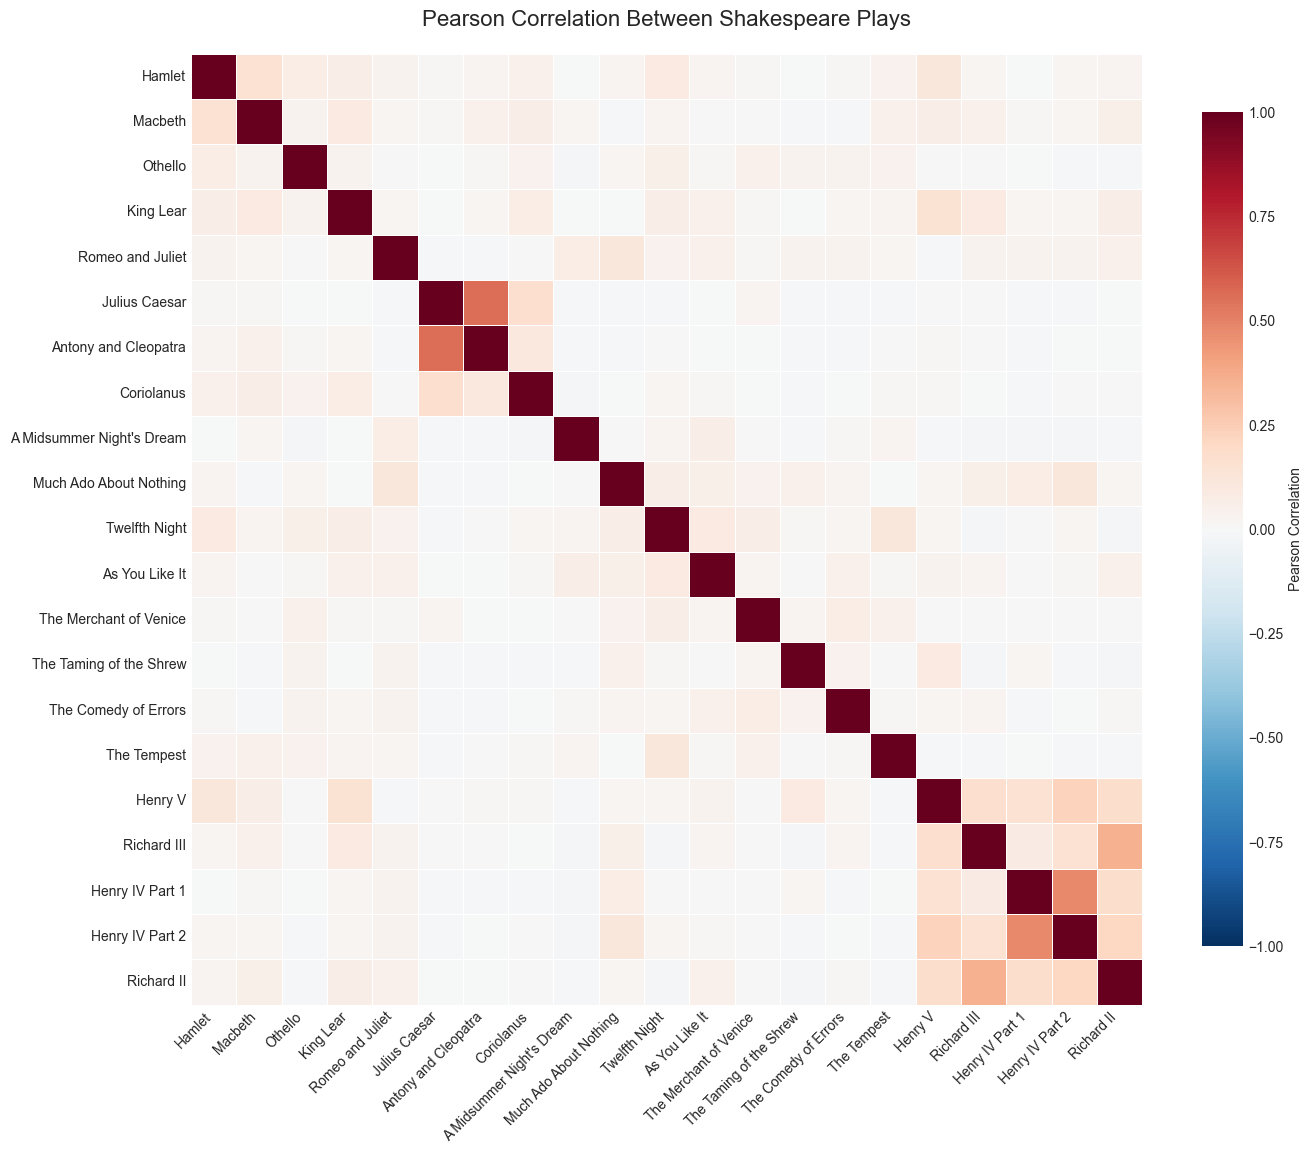

In [13]:
# Create heatmap
plt.figure(figsize=(14, 12))

# Create heatmap with better color scheme
sns.heatmap(
    df_corr,
    cmap="RdBu_r",  # Red-Blue diverging colormap
    center=0,  # Center at 0
    vmin=-1,
    vmax=1,  # Correlation range
    square=True,  # Square cells
    linewidths=0.5,  # Grid lines
    cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
    annot=False,  # Set to True if you want numbers in cells
)

plt.title("Pearson Correlation Between Shakespeare Plays", fontsize=16, pad=20)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
plt.savefig("pearson_heatmap.png", dpi=300, bbox_inches="tight")

plt.show()

### Find Most and Least Similar Pairs

In [14]:
df_corr.index.name = None
df_corr.columns.name = None

mask = np.triu(np.ones(df_corr.shape, dtype=bool), k=1)

corr_long = df_corr.where(mask).stack().reset_index(name="Correlation")

corr_long.columns = ["Play_1", "Play_2", "Correlation"]

# Sort
corr_sorted = corr_long.sort_values("Correlation", ascending=False).reset_index(
    drop=True
)

# Quick genre lookup dictionary (faster + cleaner than filtering df_plays every time)
genre_map = dict(zip(df_plays["play"], df_plays["genre"]))


# Print top / bottom pairs
def print_pairs(df_pairs, title):
    print("=" * 80)
    print(title)
    print("=" * 80)
    for _, row in df_pairs.iterrows():
        g1 = genre_map.get(row["Play_1"], "unknown")
        g2 = genre_map.get(row["Play_2"], "unknown")
        print(f"{row['Play_1']} ({g1}) <--> {row['Play_2']} ({g2})")
        print(f"  Correlation: {row['Correlation']:.3f}\n")


print_pairs(corr_sorted.head(5), "TOP 5 MOST SIMILAR PLAY PAIRS")
print_pairs(
    corr_long.sort_values("Correlation", ascending=True).head(5),
    "TOP 5 LEAST SIMILAR PLAY PAIRS",
)

TOP 5 MOST SIMILAR PLAY PAIRS
Julius Caesar (tragedy) <--> Antony and Cleopatra (tragedy)
  Correlation: 0.558

Henry IV Part 1 (history) <--> Henry IV Part 2 (history)
  Correlation: 0.483

Richard III (history) <--> Richard II (history)
  Correlation: 0.359

Henry V (history) <--> Henry IV Part 2 (history)
  Correlation: 0.229

Henry IV Part 2 (history) <--> Richard II (history)
  Correlation: 0.204

TOP 5 LEAST SIMILAR PLAY PAIRS
A Midsummer Night's Dream (comedy) <--> Henry IV Part 2 (history)
  Correlation: -0.023

The Taming of the Shrew (comedy) <--> Richard II (history)
  Correlation: -0.022

A Midsummer Night's Dream (comedy) <--> Henry IV Part 1 (history)
  Correlation: -0.021

Coriolanus (tragedy) <--> A Midsummer Night's Dream (comedy)
  Correlation: -0.021

Othello (tragedy) <--> A Midsummer Night's Dream (comedy)
  Correlation: -0.020



## Pearson Correlation Interpretation

### Most Similar Document Pairs

1. **Julius Caesar ↔ Antony and Cleopatra (r = 0.558)**

Both plays are Roman tragedies centered on overlapping political figures and institutions (Caesar, Antony, Rome, military leadership). The high correlation suggests that shared geopolitical setting and political vocabulary strongly drive lexical similarity.

2. **Henry IV Part 1 ↔ Henry IV Part 2 (r = 0.483)**

This is unsurprising, as the plays are direct continuations of one another. They share characters (Falstaff, Prince Hal), historical context, and dynastic themes. The strong correlation confirms that sequential historical narratives produce consistent lexical patterns.

Notably, the remaining highly similar pairs are also English histories, reinforcing that dynastic and national political discourse produces measurable lexical clustering.


### Least Similar Document Pairs

1. **A Midsummer Night's Dream ↔ Henry IV Part 2 (r = -0.023)**

*A Midsummer Night's Dream* is a magical comedy set in Athens featuring fairies, lovers, and amateur actors, with vocabulary centered on enchantment, courtship, and theatrical performance ("fairy," "helena," "thisbe," "wall," "athens"). *Henry IV Part 2* is a political history focused on English nobility, rebellion, military campaigns, and royal succession, featuring vocabulary of statecraft and warfare ("bardolph," "falstaff," "harry," "john"). These plays represent opposite poles of Shakespeare's corpus—fantastical romance vs. political realism—and share virtually no lexical overlap.

2. **The Taming of the Shrew ↔ Richard II (r = -0.022)**

*The Taming of the Shrew* is an Italian domestic comedy about courtship, marriage, and social hierarchy within a merchant family ("lucentio," "kate," "bianca," "petruchio," "baptista," "padua"). *Richard II* is an English political history about royal deposition, divine right, and aristocratic rebellion ("bolingbroke," "richard," "york," "gaunt," "hereford"). The negative correlation reflects completely disjoint thematic and lexical domains—domestic/romantic vs. political/historical, Italian urban setting vs. English court and countryside.
  
These negative (near-zero) correlations indicate minimal overlap in vocabulary distribution. 

Notably, *A Midsummer Night's Dream* appears in three of the five least similar pairs, suggesting it occupies an exceptionally distinct lexical space within the corpus, likely due to its unique magical/supernatural vocabulary.

This makes intuitive sense:

- *A Midsummer Night’s Dream* centers on mythological, romantic, and pastoral themes (fairies, lovers, Athens).
- The histories focus on political conflict, warfare, monarchy, and national identity.
- Tragedies like *Othello* and *Coriolanus* revolve around military hierarchy and political authority.

---

### Research Questions Emerging from Correlation Patterns

- Why do Roman tragedies show the strongest inter-play correlation despite not being a continuous narrative?
- Why are history plays' internal correlations surprisingly low despite shared characters and settings?
- Temporal scope creates variation (Richard II's medieval court vs. Henry V's Renaissance warfare)
- What makes *A Midsummer Night's Dream* such an extreme outlier? Would *The Tempest* (another magical play) show similar outlier status? 
    - Do magical/supernatural plays form a distinct sub-genre with unique lexical profiles?

---

**Conclusion:**  

The Pearson correlation analysis suggests that genre categories have measurable but moderate lexical coherence. Clear clustering among the English histories and the Roman political tragedies indicates that shared historical setting and character networks strongly influence vocabulary patterns. However, the relatively modest magnitude of even the highest correlation (r = 0.558) indicates that lexical overlap across plays remains limited.

Overall, Shakespeare’s vocabulary appears to be shaped more by specific dramatic context—character ensembles, geopolitical setting, and thematic focus—than by broad genre conventions alone. These findings suggest that plot-level particularity exerts a stronger influence on lexical distribution than abstract genre classification, highlighting both the specificity of Shakespeare’s dramatic worlds and his considerable lexical range.

## STEP 3: Syntactic Complexity Analysis

### Selection of Plays for Syntactic Comparison

**Selected Plays:**
- *Julius Caesar* (tragedy)  
- *Antony and Cleopatra* (tragedy)

### Reason for Selection

These two plays were selected because they show the strongest lexical similarity in the corpus (r = 0.558). Both the TF-IDF and Pearson correlation analyses indicate substantial shared vocabulary.

**Shared distinctive terms:**  
“antony,” “caesar,” and “rome” appear in both plays, reflecting:

- Character continuity (Antony and Caesar/Octavius)
- Shared Roman political setting
- Common military and imperial vocabulary

At the same time, each play contains distinctive terms reflecting its specific focus:

- *Julius Caesar*: “brutus,” “cassius,” “capitol,” “philippi”: conspiracy and republican politics  
- *Antony and Cleopatra*: “cleopatra,” “egypt,” “pompey,” “agrippa”: romance, empire, and the triumvirate  

Thus, the plays are lexically similar but thematically distinct.

**Despite their strong lexical similarity, do *Julius Caesar* and *Antony and Cleopatra* differ in syntactic complexity?**


In [15]:
# Select Play
play1_name = "Julius Caesar"
play2_name = "Antony and Cleopatra"

# Get texts
play1_text = df_plays[df_plays["play"] == play1_name]["text_norm"].values[0]
play2_text = df_plays[df_plays["play"] == play2_name]["text_norm"].values[0]

### Define Syntactic Complexity Functions

In [16]:
nlp = spacy.load("en_core_web_sm")

nlp.max_length = 2000000

In [17]:
def calculate_syntactic_complexity(text, play_name):

    # Parse text
    doc = nlp(text[:500000])  # Use this to add constrain

    # Initialize counters
    sentences = list(doc.sents)
    n_sentences = len(sentences)

    total_words = 0
    total_clauses = 0
    total_dependent_clauses = 0
    total_coordination = 0
    total_complex_nominals = 0

    for sent in sentences:
        # Word count
        words = [token for token in sent if not token.is_punct]
        total_words += len(words)

        # Clause count (simplified: count verbs)
        verbs = [token for token in sent if token.pos_ == "VERB"]
        total_clauses += len(verbs)

        # Dependent clauses (advcl, acl, ccomp, xcomp)
        dep_clauses = [
            token for token in sent if token.dep_ in ["advcl", "acl", "ccomp", "xcomp"]
        ]
        total_dependent_clauses += len(dep_clauses)

        # Coordination (conj)
        coord = [token for token in sent if token.dep_ == "conj"]
        total_coordination += len(coord)

        # Complex nominals (noun with modifiers)
        nouns_with_mods = [
            token
            for token in sent
            if token.pos_ == "NOUN"
            and any(
                child.dep_ in ["amod", "nmod", "acl", "relcl"]
                for child in token.children
            )
        ]
        total_complex_nominals += len(nouns_with_mods)

    # Calculate measures
    results = {
        "play": play_name,
        "sentences": n_sentences,
        "MLS": total_words / n_sentences if n_sentences > 0 else 0,
        "C/S": total_clauses / n_sentences if n_sentences > 0 else 0,
        "DC/S": total_dependent_clauses / n_sentences if n_sentences > 0 else 0,
        "Coord/S": total_coordination / n_sentences if n_sentences > 0 else 0,
        "CN/S": total_complex_nominals / n_sentences if n_sentences > 0 else 0,
    }

    return results, doc

### Calculate Complexity for Both Plays

In [18]:
# Calculate for Play 1
results1, doc1 = calculate_syntactic_complexity(play1_text, play1_name)

# Calculate for Play 2
results2, doc2 = calculate_syntactic_complexity(play2_text, play2_name)

### Create Summary Table

In [19]:
# Create comparison table
df_syntax = pd.DataFrame([results1, results2])
df_syntax = df_syntax.set_index("play")

# Format for display
df_syntax_display = df_syntax.copy()
for col in ["MLS", "C/S", "DC/S", "Coord/S", "CN/S"]:
    df_syntax_display[col] = df_syntax_display[col].round(2)


print("SYNTACTIC COMPLEXITY COMPARISON")

print(df_syntax_display.to_string())
print("\nMeasures:")
print("  MLS = Mean Length of Sentence")
print("  C/S = Clauses per Sentence")
print("  DC/S = Dependent Clauses per Sentence")
print("  Coord/S = Coordination per Sentence")
print("  CN/S = Complex Nominals per Sentence")

# Save to CSV
df_syntax_display.to_csv("syntactic_complexity.csv")

SYNTACTIC COMPLEXITY COMPARISON
                      sentences    MLS   C/S  DC/S  Coord/S  CN/S
play                                                             
Julius Caesar              1440  15.37  1.97  0.89     0.69  0.58
Antony and Cleopatra       2024  13.92  1.79  0.73     0.51  0.54

Measures:
  MLS = Mean Length of Sentence
  C/S = Clauses per Sentence
  DC/S = Dependent Clauses per Sentence
  Coord/S = Coordination per Sentence
  CN/S = Complex Nominals per Sentence


### Visualize Syntactic Differences

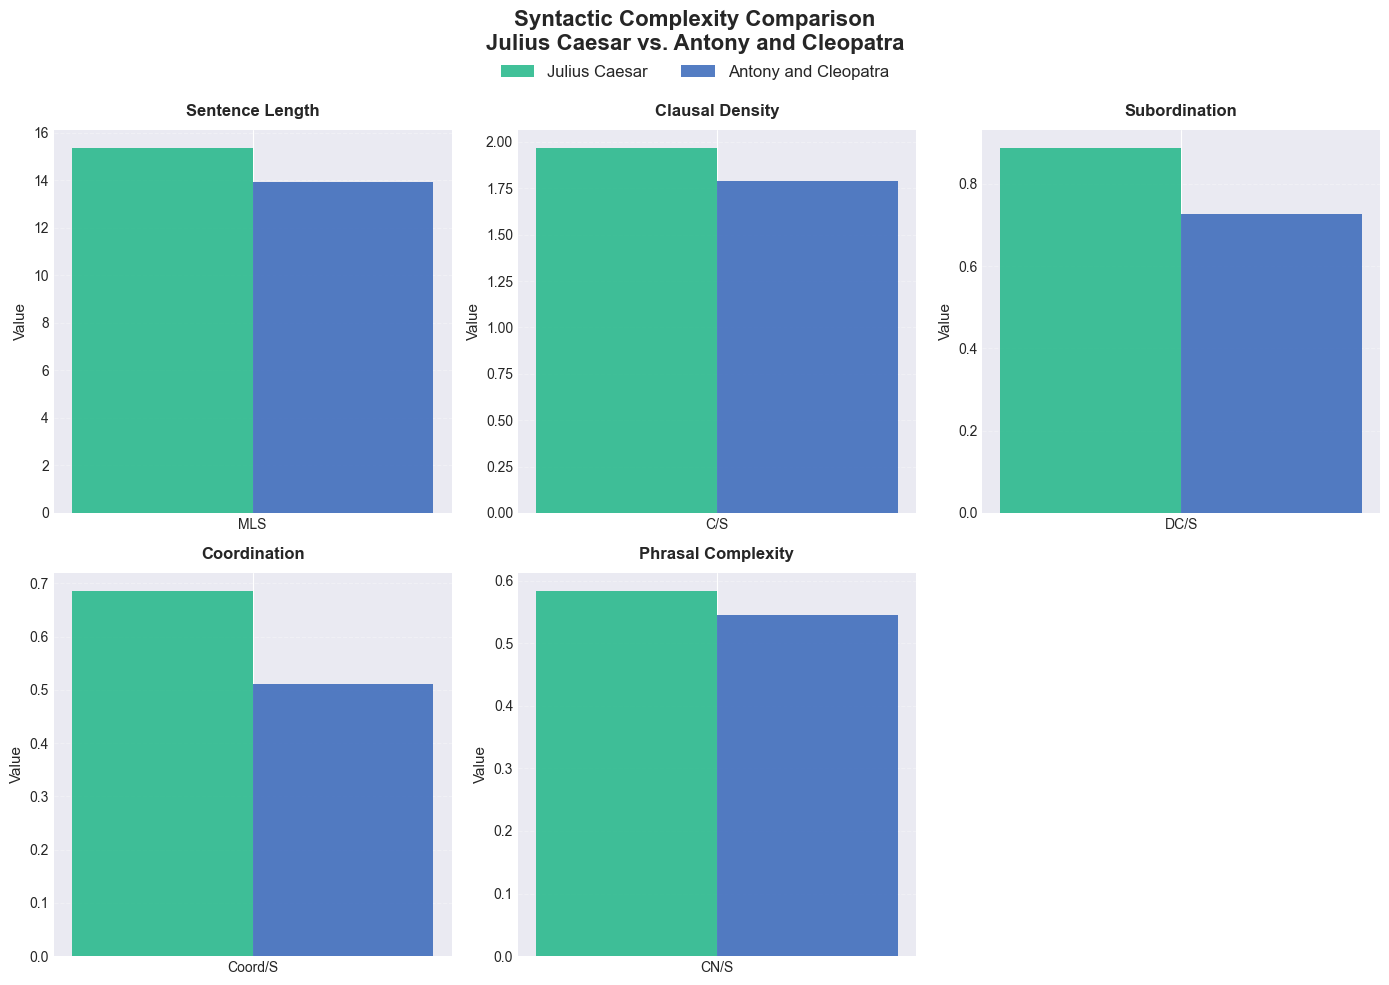

In [20]:
# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

# Colors for the two plays
color1 = "#20b787"
color2 = "#3666b9"

measures_data = {
    "Sentence Length": ("MLS", results1["MLS"], results2["MLS"]),
    "Clausal Density": ("C/S", results1["C/S"], results2["C/S"]),
    "Subordination": ("DC/S", results1["DC/S"], results2["DC/S"]),
    "Coordination": ("Coord/S", results1["Coord/S"], results2["Coord/S"]),
    "Phrasal Complexity": ("CN/S", results1["CN/S"], results2["CN/S"]),
}

# Create each subplot
for idx, (title, (label, val1, val2)) in enumerate(measures_data.items()):
    if idx >= 5:  # Only plot first 5
        break

    ax = axes[idx]

    x = np.arange(1)
    width = 0.35

    # Create bars
    ax.bar(x - width / 2, [val1], width, label=play1_name, color=color1, alpha=0.85)
    ax.bar(x + width / 2, [val2], width, label=play2_name, color=color2, alpha=0.85)

    # Styling
    ax.set_ylabel("Value", fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold", pad=10)
    ax.set_xticks([0])
    ax.set_xticklabels([label], fontsize=10)
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(axis="x", length=0)
    ax.set_ylim(bottom=0)

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.94),
    ncol=2,
    fontsize=12,
    framealpha=0.95,
)

# Overall title
fig.suptitle(
    f"Syntactic Complexity Comparison\n{play1_name} vs. {play2_name}",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
for i in range(5, len(axes)):
    axes[i].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save
output_path = output_dir / "syntactic_comparison_faceted.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

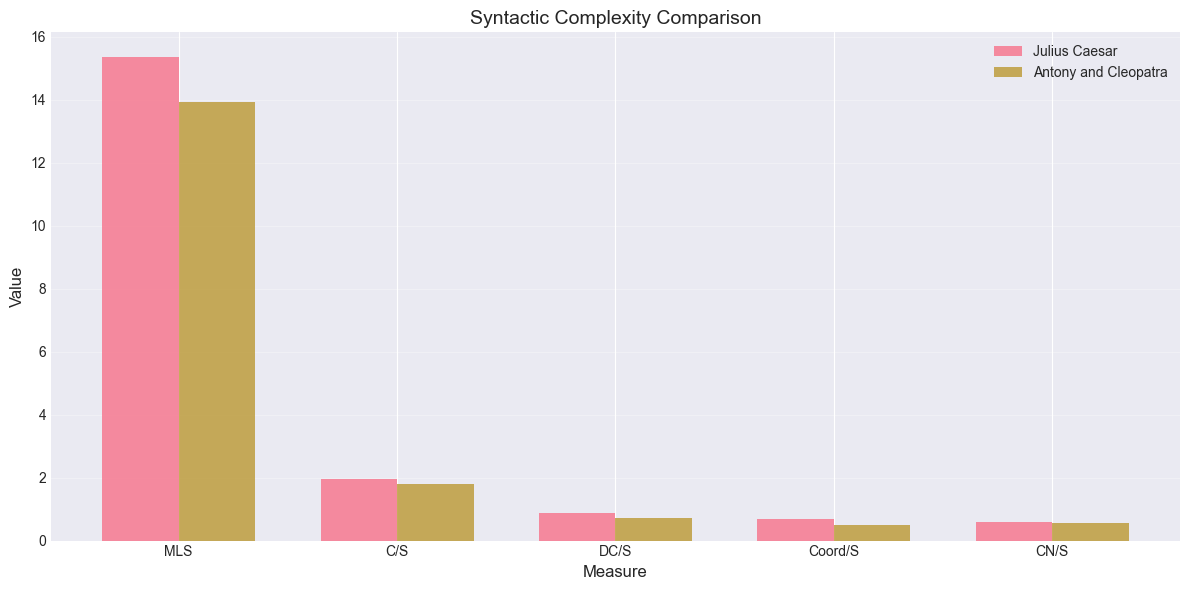

In [21]:
# Create bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

measures = ["MLS", "C/S", "DC/S", "Coord/S", "CN/S"]
x = np.arange(len(measures))
width = 0.35

play1_values = [results1[m] for m in measures]
play2_values = [results2[m] for m in measures]

ax.bar(x - width / 2, play1_values, width, label=play1_name, alpha=0.8)
ax.bar(x + width / 2, play2_values, width, label=play2_name, alpha=0.8)

ax.set_xlabel("Measure", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Syntactic Complexity Comparison", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(measures)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("syntactic_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

### Extract Example Sentences for Interpretation

In [ ]:
def find_example_sentence_with_context(doc, original_text, criterion="longest"):

    sentences = list(doc.sents)

    if criterion == "longest":
        sent = max(sentences, key=lambda s: len([t for t in s if not t.is_punct]))
    elif criterion == "most_complex":
        sent = max(
            sentences,
            key=lambda s: len(
                [t for t in s if t.dep_ in ["advcl", "acl", "ccomp", "xcomp", "relcl"]]
            ),
        )
    elif criterion == "most_coordination":
        sent = max(sentences, key=lambda s: len([t for t in s if t.dep_ == "conj"]))

    # Get the sentence text from spaCy
    sent_text = sent.text.strip()

    # Calculate metrics for this sentence
    words = [t for t in sent if not t.is_punct]
    dep_clauses = [
        t for t in sent if t.dep_ in ["advcl", "acl", "ccomp", "xcomp", "relcl"]
    ]
    coord = [t for t in sent if t.dep_ in ["conj", "cc"]]

    metrics = {
        "words": len(words),
        "dep_clauses": len(dep_clauses),
        "coord": len(coord),
    }

    return sent_text, metrics

In [ ]:
print("EXAMPLE SENTENCES FROM NORMALIZED TEXT:")

# Play 1 - Longest
print(f"\n{play1_name} - Longest Sentence:")
print("-" * 80)
example1, metrics1 = find_example_sentence_with_context(doc1, play1_text, "longest")
print(
    f"[{metrics1['words']} words, {metrics1['dep_clauses']} dependent clauses, {metrics1['coord']} coordination markers]"
)
print()
# Truncate if very long
if len(example1) > 600:
    print(example1[:600] + "...")
else:
    print(example1)

EXAMPLE SENTENCES FROM NORMALIZED TEXT:

Julius Caesar - Longest Sentence:
--------------------------------------------------------------------------------
[125 words, 9 dependent clauses, 13 coordination markers]

over thy wounds now do i prophesy
(which like dumb mouths do ope their ruby lips
to beg the voice and utterance of my tongue)
a curse shall light upon the limbs of men;
domestic fury and fierce civil strife
shall cumber all the parts of italy;
blood and destruction shall be so in use
and dreadful objects so familiar
that mothers shall but smile when they behold
their infants quartered with the hands of war,
all pity choked with custom of fell deeds;
and caesar's spirit, ranging for revenge,
with ate by his side come hot from hell,
shall in these confines with a monarch's voice
cry "havoc!"


In [ ]:
# Play 2 - Longest
print(f"\n{play2_name} - Longest Sentence:")
print("-" * 80)
example2, metrics2 = find_example_sentence_with_context(doc2, play2_text, "longest")
print(
    f"[{metrics2['words']} words, {metrics2['dep_clauses']} dependent clauses, {metrics2['coord']} coordination markers]"
)
print()
if len(example2) > 600:
    print(example2[:600] + "...")
else:
    print(example2)


Antony and Cleopatra - Longest Sentence:
--------------------------------------------------------------------------------
[86 words, 4 dependent clauses, 19 coordination markers]

nay, nay, octavia, not only that--
that were excusable, that and thousands more
of semblable import--but he hath waged
new wars 'gainst pompey; made his will and read it
to public ear;
spoke scantly of me; when perforce he could not
but pay me terms of honor, cold and sickly
he vented them, most narrow measure lent me;
when the best hint was given him, he not took 't,
or did it from his teeth.


In [ ]:
# Play 1 - Most Complex
print(f"\n{play1_name} - Most Syntactically Complex (most dependent clauses):")
print("-" * 80)
example3, metrics3 = find_example_sentence_with_context(
    doc1, play1_text, "most_complex"
)
print(
    f"[{metrics3['words']} words, {metrics3['dep_clauses']} dependent clauses, {metrics3['coord']} coordination markers]"
)
print()
if len(example3) > 600:
    print(example3[:600] + "...")
else:
    print(example3)


Julius Caesar - Most Syntactically Complex (most dependent clauses):
--------------------------------------------------------------------------------
[105 words, 11 dependent clauses, 10 coordination markers]

and since you know you cannot see yourself
so well as by reflection, i, your glass,
will modestly discover to yourself
that of yourself which you yet know not of.
and be not jealous on me, gentle brutus.
were i a common laughter, or did use
to stale with ordinary oaths my love
to every new protester; if you know
that i do fawn on men and hug them hard
and after scandal them, or if you know
that i profess myself in banqueting
to all the rout, then hold me dangerous.


In [ ]:
# Play 2 - Most Complex
print(f"\n{play2_name} - Most Syntactically Complex (most dependent clauses):")
print("-" * 80)
example4, metrics4 = find_example_sentence_with_context(
    doc2, play2_text, "most_complex"
)
print(
    f"[{metrics4['words']} words, {metrics4['dep_clauses']} dependent clauses, {metrics4['coord']} coordination markers]"
)
print()
if len(example4) > 600:
    print(example4[:600] + "...")
else:
    print(example4)


Antony and Cleopatra - Most Syntactically Complex (most dependent clauses):
--------------------------------------------------------------------------------
[41 words, 8 dependent clauses, 0 coordination markers]

when it pleaseth their deities to take the wife of a
man from him, it shows to man the tailors of the
earth; comforting therein, that when old robes are
worn out, there are members to make new.


## Step 3: Syntactic Complexity Interpretation

### How do the two texts differ in syntactic complexity?

Despite their high lexical similarity (r = 0.558), *Julius Caesar* and *Antony and Cleopatra* show meaningful differences in syntactic complexity:

*Julius Caesar* uses longer, more complex sentences:
- Longer sentences: MLS = 15.37 vs. 13.92 (about 10% longer)
- More clauses per sentence: C/S = 1.97 vs. 1.79
- More subordination: DC/S = 0.89 vs. 0.73 (22% more dependent clauses)
- More coordination: Coord/S = 0.69 vs. 0.51 (35% more "and," "but," "or")
- More complex noun phrases: CN/S = 0.58 vs. 0.54

In Summary: *Julius Caesar* consistently shows higher complexity across all five measures. The plays share similar vocabulary (same characters, Roman setting, political themes), but *Julius Caesar* builds longer, more intricate sentences with more subordinate clauses and coordinated phrases.

### Do these differences align with or complicate your earlier lexical findings?

These syntactic differences complicate what we found earlier with TF-IDF and correlation analysis.

From the earlier analysis, we saw that *Julius Caesar* and *Antony and Cleopatra* have the highest correlation in the corpus (r = 0.558). They share distinctive vocabulary like "caesar," "antony," and "rome," which makes sense because they're both Roman political plays with overlapping characters.

But the syntactic analysis shows something different. Even though they use similar words, *Julius Caesar* builds more complex sentences. It has longer sentences, more subordinate clauses, and more coordination. *Antony and Cleopatra* uses the same Roman vocabulary but in shorter, simpler sentence structures.

This means that sharing vocabulary doesn't necessarily mean sharing sentence structure. The plays talk about the same things (Roman politics, Caesar, Antony) but say them differently. *Julius Caesar* uses complex syntax for public speeches and political debates. *Antony and Cleopatra* uses simpler syntax for private conversations between lovers.

So the findings don't completely align. The lexical analysis showed these plays are very similar, but the syntactic analysis reveals important differences in how they're written. Both findings are valuable—they just tell us different things about the plays.

### What kinds of rhetorical or stylistic practices might these syntactic patterns reflect?

The syntactic differences make sense when you think about what's happening in each play.

*Julius Caesar* has higher complexity because it's full of public speeches. The play is about political conspiracy, senate debates, and persuading crowds. Brutus and Antony give long funeral speeches trying to convince the Roman people. Cassius argues with Brutus about strategy. These situations require complex sentences—you need subordinate clauses to build logical arguments, and you need coordination to list reasons and connect ideas.

For example, when Brutus speaks to the crowd, he uses complex syntax to make his case: "If there be any in this assembly, any dear friend of Caesar's, to him I say that Brutus' love to Caesar was no less than his..." This kind of sentence structure helps build a persuasive argument.

*Antony and Cleopatra* has lower complexity because it's more about personal relationships. Much of the play is private conversations between Antony and Cleopatra—lovers arguing, reconciling, expressing emotions. This kind of dialogue works better with shorter, more direct sentences. When Cleopatra is upset, she doesn't give long political speeches—she says things like "I am dying, Egypt, dying."

The patterns suggest:
- *Julius Caesar* uses complex syntax for public persuasion (convincing crowds, making political arguments)
- *Antony and Cleopatra* uses simpler syntax for private emotion (expressing feelings, having personal conversations)

Even though both plays are about Roman politics and share the same vocabulary, Shakespeare writes them differently based on the dramatic situation. Political speeches need one kind of sentence structure, and intimate conversations need another.

## STEP 4: SYNTHESIS

### Triangulating Evidence Across All Three Approaches


### The Question:

Are Shakespeare's genre categories (tragedy, comedy, history) actually reflected in how the plays are written, or are they just based on plot and theme? And when two plays use similar vocabulary, does that mean they're written in the same style?


### Evidence from TF-IDF:

The TF-IDF analysis showed that distinctive vocabulary is mostly about the specific content of each play, not really about genre.

What I found:
- Character names are the most distinctive terms in almost every play (like "brutus" and "cassius" in *Julius Caesar*, "thisbe" and "helena" in *A Midsummer Night's Dream*)
- Place names create clustering: Roman plays all have "rome" and "capitol"; Italian comedies have "venice" and "padua"
- There are some genre patterns (tragedies mention "blood" and "death" more; comedies mention "love" and "marry"), but they're not as strong as I expected
- The most distinctive words are usually specific to that play's story—character names, important objects (like Othello's handkerchief), and locations

What this means: The vocabulary that makes each play unique is more about its specific story, characters, and setting than about being a tragedy or comedy.


### Evidence from Pearson Correlation:

The correlation analysis showed that plays do cluster somewhat by genre, but not as cleanly as I expected.

Key findings:
- The two most similar plays are *Julius Caesar* and *Antony and Cleopatra* (r = 0.558), these are both Roman political tragedies with overlapping characters
- Second most similar are *Henry IV Part 1* and *Part 2* (r = 0.483), this makes sense since they're basically one long play split in two
- The least similar plays are *A Midsummer Night's Dream* and various history plays (r ≈ -0.02), which means magical comedy vs. political history have almost nothing in common

Patterns I noticed:
- Roman plays (*Julius Caesar*, *Antony and Cleopatra*, *Coriolanus*) are more similar to each other than to other tragedies
- History plays are surprisingly different from each other—each one focuses on different political situations
- *A Midsummer Night's Dream* is really different from everything else (it showed up in three of the five least-similar pairs)

What this means: Plays cluster more by specific themes and settings (like "Roman politics" or "Italian city life") than by broad genres. Also, even the most similar plays only have moderate correlation (r = 0.558), which shows Shakespeare uses really varied vocabulary even when writing about similar topics.


### Evidence from Syntactic Complexity:

The syntactic analysis of *Julius Caesar* and *Antony and Cleopatra* showed something surprising: even though these plays use similar vocabulary, they're written quite differently.

The comparison:
- *Julius Caesar* is more complex: longer sentences (MLS = 15.37 vs. 13.92), more subordinate clauses (DC/S = 0.89 vs. 0.73), more coordination (Coord/S = 0.69 vs. 0.51)
- *Antony and Cleopatra* is simpler across all measures

Why this matters:
- *Julius Caesar* has lots of public speeches—senate debates, funeral orations, political arguments. These need complex sentences with lots of subordinate clauses to build logical arguments
- *Antony and Cleopatra* has more private conversations between lovers. These use shorter, more direct sentences for emotional impact

What this means: You can use the same vocabulary (both plays talk about Caesar, Antony, and Roman politics) but write in different styles depending on what's happening in the scene. Political speeches need one kind of sentence structure, emotional conversations need another.


### Synthesis and Conclusion:

After looking at all three methods together, here's what I learned about how Shakespeare writes:

**The main findings:**

1. **Vocabulary is about content, not genre**: The TF-IDF analysis showed that what makes each play's vocabulary distinctive is mostly its specific characters, settings, and plot. Character names and place names dominate the distinctive terms. Genre (tragedy vs. comedy) matters less than I thought.

2. **Plays cluster by specific themes, not just broad genres**: The correlation analysis showed that Roman plays cluster together, Italian comedies cluster together, and so on. But "tragedy" as a whole doesn't form a super tight cluster. The highest correlation in the whole corpus was only r = 0.558, which is moderate, not strong. This means even similar plays use pretty different vocabulary overall.

3. **Syntax works differently from vocabulary**: Even though *Julius Caesar* and *Antony and Cleopatra* have high lexical similarity (r = 0.558), they have different syntactic complexity. *Julius Caesar* uses longer, more complex sentences because it's full of formal speeches. *Antony and Cleopatra* uses simpler sentences because it's more about personal conversations. This shows that Shakespeare adjusts how he builds sentences based on the dramatic situation, not just on what words he's using.

**What this all means:**

Shakespeare's genre categories are real but they're not as strong as I expected. When I started, I thought tragedies would all cluster together and be clearly different from comedies. But what I found is more complicated:

- The strongest patterns are at a more specific level: Roman plays, Italian comedies, magical plays, etc.
- Vocabulary is driven mainly by the content of each play (who's in it, where it takes place, what happens)
- Syntax is driven by the dramatic mode (whether characters are giving speeches or having conversations, making arguments or expressing emotions)

The disconnect between lexical and syntactic findings is also important. *Julius Caesar* and *Antony and Cleopatra* share a lot of vocabulary (same characters, same Roman world), but they're structured differently because one is about public politics and one is about private passion. This suggests that Shakespeare thinks about word choice and sentence structure separately—he can use the same vocabulary but arrange it differently depending on what the scene needs.


## Summary of Outputs

### Files Generated:

**TF-IDF Analysis:**
1. `tfidf_all_plays.png` - Top 15 distinctive terms for all 21 plays (7×3 grid)
2. `tfidf_all_tragedies.png` - Top 15 distinctive terms for all 8 tragedies
3. `tfidf_all_comedies.png` - Top 15 distinctive terms for all 8 comedies
4. `tfidf_all_histories.png` - Top 15 distinctive terms for all 5 histories
5. `tfidf_by_genre_average.png` - Average distinctive terms by genre (3-panel comparison)
6. `tfidf_comparison.png` - Side-by-side comparison of 6 representative plays

**Pearson Correlation Analysis:**
7. `pearson_heatmap.png` - Correlation matrix for all 21 plays

**Syntactic Complexity Analysis:**
8. `syntactic_comparison_faceted.png` - Faceted comparison of *Julius Caesar* vs. *Antony and Cleopatra* across 5 measures

**Data Tables:**
9. `tfidf_results.csv` - Complete TF-IDF top terms for all plays
10. `syntactic_complexity.csv` - Syntactic complexity measures for selected plays